# Assignment 2: Classification


# The Data

In [1]:
import pandas as pd
import os

# Note the use of *relative path*; your assignments should all use relative rather than absolute paths
TITANIC_PATH = "./assignment_2"

train_data = pd.read_csv( os.path.join(TITANIC_PATH, "train.csv") )
test_data  = pd.read_csv( os.path.join(TITANIC_PATH, "test.csv")  )

Since test_data does not have 'Survived', I choose to split training data into a smaller training set and an out of sample set for calculating accuracy, call it vali_data. It serves as a test set. I did a 8:2 split because I think it might be a good division to keep our training set large and validation set significant.

I set shuffle = False for the split in order to get consistent results every time I run but the order of passengers doesn't matter in this problem and it might be a good idea to shuffle.

In [2]:
from sklearn.model_selection import train_test_split
train_data, vali_data = train_test_split(train_data, test_size=0.2, shuffle=False)

In [3]:
# Check split results
vali_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 712 to 890
Data columns (total 12 columns):
PassengerId    179 non-null int64
Survived       179 non-null int64
Pclass         179 non-null int64
Name           179 non-null object
Sex            179 non-null object
Age            149 non-null float64
SibSp          179 non-null int64
Parch          179 non-null int64
Ticket         179 non-null object
Fare           179 non-null float64
Cabin          42 non-null object
Embarked       178 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 18.2+ KB


# Brief Exploratory Data Analysis

In [4]:
train_data.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


Looking at the columns, PassengerID, Ticket number and Name of passengers are unlikely related to their survival.
Other than these three, Sex, Cabin, Embarked, Pclass, and survived are all categorical, Age, SibSp, Parch and Fare are numeric attributes

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 711
Data columns (total 12 columns):
PassengerId    712 non-null int64
Survived       712 non-null int64
Pclass         712 non-null int64
Name           712 non-null object
Sex            712 non-null object
Age            565 non-null float64
SibSp          712 non-null int64
Parch          712 non-null int64
Ticket         712 non-null object
Fare           712 non-null float64
Cabin          162 non-null object
Embarked       711 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


From the information of training set, Age, Cabin and Embarked have missing data because they have less than 712 data.

In [6]:
train_data.groupby("Sex").agg(["mean", "count"])["Survived"]

,mean,count
Sex,,
female,0.742188,256
male,0.192982,456


In the table above, in our smaller training set, female seems to be a strong indicator for survive.

In the table below, it is better to be in Pclass 1 and came with 1 or 2 family members. Too much family members might be a "burden" but having 1 or 2 seems to be better than being alone.

I would include these variables in my basic model.

In [7]:
train_data.groupby("Pclass").agg(["mean", "count"])["Survived"]

,mean,count
Pclass,,
1,0.611429,175
2,0.489796,147
3,0.253846,390


In [8]:
train_data.groupby("SibSp").agg(["mean", "count"])["Survived"]

,mean,count
SibSp,,
0,0.356250,480
1,0.526627,169
2,0.461538,26
3,0.214286,14
4,0.214286,14
5,0.000000,5
8,0.000000,4


In [9]:
train_data.groupby("Parch").agg(["mean", "count"])["Survived"]

,mean,count
Parch,,
0,0.359116,543
1,0.510870,92
2,0.515152,66
3,0.500000,2
4,0.000000,4
5,0.250000,4
6,0.000000,1


# Preparing Data in Simplest Way

- Fill up missing values: median for numerical values, most frequent one for categorical values
- Conduct one hot encoding for categorical variables "Sex" and "Pclass"
- Use sklearn pipeline to transform all the data, train and test

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
# A class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
# This function is from Lecture Notes
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
num_features = ["Age", "SibSp", "Parch", "Fare"]
num_pipeline = Pipeline([("select_numeric", DataFrameSelector( num_features )),
                            ("imputer", SimpleImputer(strategy="median")),])

# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

cat_features = ["Sex", "Pclass"]

In [11]:
# Categorical pipleine: Fill up Categorical missing values with most frequent values and using One Hot Encoding
from sklearn.preprocessing import OneHotEncoder 

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector( cat_features )),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [12]:
# transform training data
X_train = preprocess_pipeline.fit_transform(train_data)

# Note: All the columns in untransformed train_data are NOT in X_train, especially the target Survived !
print(train_data.columns)
print(X_train.shape)
X_train

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(712, 9)


array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  1., ...,  0.,  0.,  1.],
       [24.,  0.,  0., ...,  1.,  0.,  0.],
       [28.,  0.,  0., ...,  1.,  0.,  0.]])

- X_train is an array without column names
- number of column is 9 due to one hot encoding, 4+2+3

In [13]:
# Transform the test data too
X_test = preprocess_pipeline.transform(test_data)
X_vali = preprocess_pipeline.transform(vali_data)

# get true y
y_train = train_data["Survived"]
y_vali = vali_data['Survived']

# Create a base model using Naive Bayes

Use a Naive Bayes classifier as the Base Model in the Recipe.

- Report the average of the cross validation scores, using 5 fold cross validation
- Use Accuracy as your Performance Metric; report the accuracy

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements


In [14]:
from sklearn.naive_bayes import GaussianNB
# Instantiate the classifier
gnb = GaussianNB()

# Train classifier
gnb.fit(
    X_train,
    y_train
)
# for calculating accuracy
y_pred = gnb.predict(X_vali)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(gnb, X_train, y_train, cv=5)

from sklearn.metrics import accuracy_score

In [15]:
model = "Naive Bayes"
cross_val_avg = scores.mean() 

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=model, sc=cross_val_avg) )

accuracy = accuracy_score(y_vali, y_pred, normalize=True)
print("{m:s}: Accuracy = {a:.2%}".format(m=model, a=accuracy) )

Naive Bayes: Avg cross val score = 0.79
Naive Bayes: Accuracy = 82.12%


# Create a Logistic Regression model with minimal feature engineering

Create a Logistic Regression classifier using only transformations that are absolutely necessary,
for example
- dealing with missing features
- categorical transformations

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

Minimal Feature engineering was conducted in the previous code, so just plug into model here.

In [16]:
from sklearn import linear_model, preprocessing, model_selection 

logistic_clf = linear_model.LogisticRegression(solver='liblinear')

# Fit the training set
_= logistic_clf.fit(X_train, y_train)

y_pred_lg = logistic_clf.predict(X_vali)

scores_lg = cross_val_score(logistic_clf, X_train, y_train, cv=5)

In [17]:
model = "Logistic Regression, version 0"
cross_val_avg = cross_val_avg = scores_lg.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=model, sc=cross_val_avg) )

accuracy = accuracy_score(y_vali, y_pred_lg, normalize=True)
print("{m:s}: Accuracy = {a:.2%}".format(m=model, a=accuracy) )


Logistic Regression, version 0: Avg cross val score = 0.78
Logistic Regression, version 0: Accuracy = 83.80%


# Perform feature engineering and create another Logistic Regression classifier

Use transformations and creation of new features to improve your first Logistic Regression classifier.

The first set of  transformations require you to convert `Age` from continuous to buckets/bins.
This means choosing how many buckets/bins and what the boundaries are.

You will make two different choices for the buckets and report the accuracy of each.
You should *clearly explain* why you made the choices that you did (based on logic, Exploratory Data Analysis, etc.).

The steps are:
- choose a set of buckets and compare your Accuracy out of sample with the first Logistic Regression classifier
- choose a *second* set of buckets and compare your Accuracy out of sample with the first Logistic Regression classifier

So you will answer two nearly identical questions.  Please report the **best** result in the **second answer**.

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

# Detailed Exploration of Age

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

First, the histogram of age shows that most people in Titanic are around their 20s.

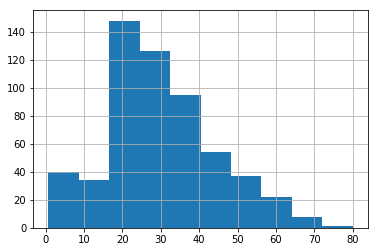

In [19]:
train_data["Age"].hist()

In [20]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,565.000000,712.000000,712.000000,712.000000
mean,356.500000,0.390449,2.301966,30.030531,0.528090,0.382022,32.509538
std,205.680983,0.488194,0.838656,14.602635,1.064342,0.813122,48.672710
min,1.000000,0.000000,1.000000,0.750000,0.000000,0.000000,0.000000
25%,178.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,356.500000,0.000000,3.000000,28.000000,0.000000,0.000000,15.022900
75%,534.250000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,712.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The oldest are 80 years old and the youngest is an infant.

The following function is used to graph survival according to the age buckets, where bucket size is the input. 

In [21]:
def GraphSurvival_Age(bucket_size):
    train_data["AgeBucket2"] = train_data["Age"] // bucket_size * bucket_size

    live = train_data[(train_data['Survived']==1) ]
    dead = train_data[(train_data['Survived']==0) ]
    live_n = live[["AgeBucket2", "Survived"]].groupby(['AgeBucket2']).count()
    dead_n = dead[["AgeBucket2", "Survived"]].groupby(['AgeBucket2']).count()
    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10,5))
    width = 3 
    plt.bar(live_n.index-width/2, 
            #using  data,
            live_n["Survived"], 
            width, 
            alpha=0.7,
            color='#22AF5F') 
    plt.bar(dead_n.index+width/2, 
            dead_n["Survived"], 
            width, 
            alpha=0.7, 
            color='#EE3224') 
    # Set the axis label
    ax.set_ylabel('Count')
    ax.set_xlabel('Age Buckets')

    # Set the chart's title
    ax.set_title('Survival Count in Age Bucket, Bucket Size = {}'.format(bucket_size))

    # Set the position of the x ticks
    ax.set_xticks(dead_n.index)

    # Set the labels for the x ticks
    xlabels = []
    for i in dead_n.index:
        i = int(i)
        xlabels.append("[{a},{b}]".format(a=i,b=i+bucket_size))
    ax.set_xticklabels(xlabels)

    # Adding the legend and showing the plot
    plt.legend(['Survived', 'Non-Survived'], loc='upper right')
    plt.grid()
    plt.show()

**Try different buckets**

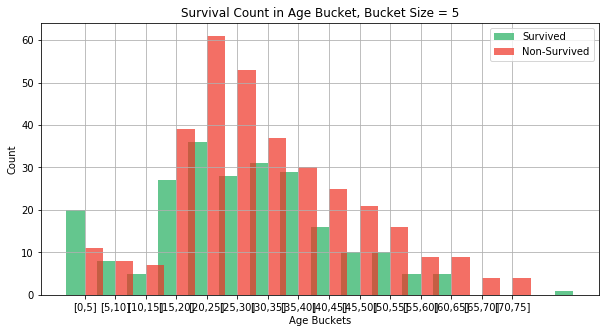

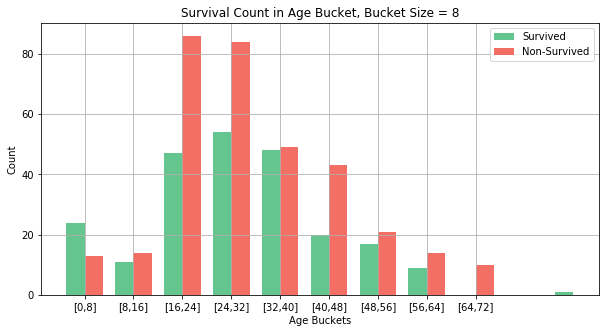

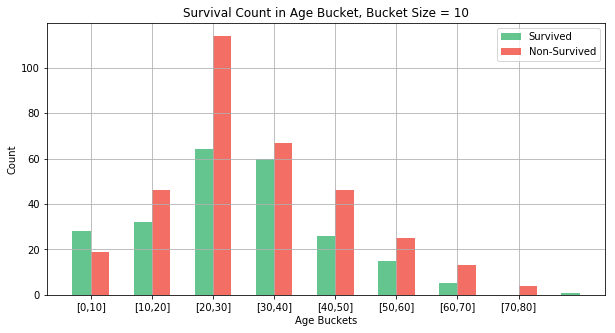

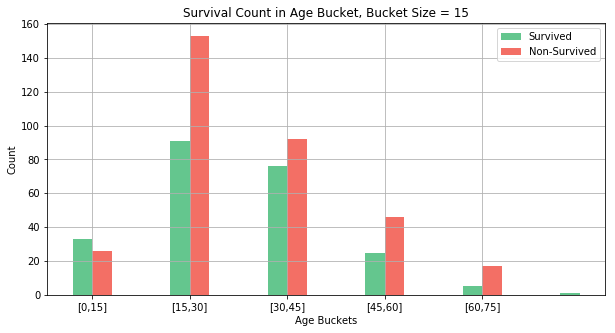

In [22]:
GraphSurvival_Age(bucket_size=5)
GraphSurvival_Age(bucket_size=8)
GraphSurvival_Age(bucket_size=10)
GraphSurvival_Age(bucket_size=15)

The graphs above show how many people survived or dead in each buckets.

To virsualize "Survived" in percentage form(survival rate), I graph means of survived of each age buckets to analyze the patterns

In [23]:
# Write functions for graph to reuse in different data
def Rate(size, Bucket, origin):
    train_data[Bucket] = train_data[origin] // size * size
    df = train_data[[Bucket, "Survived"]].groupby([Bucket]).mean()
    return df

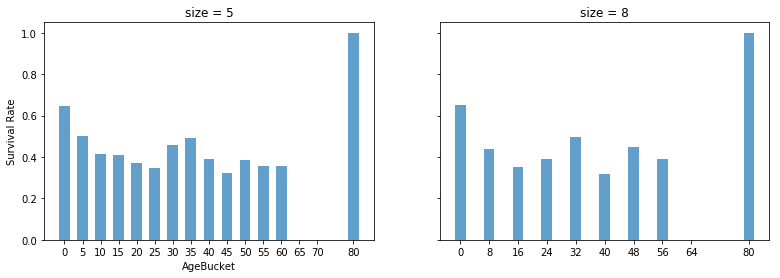

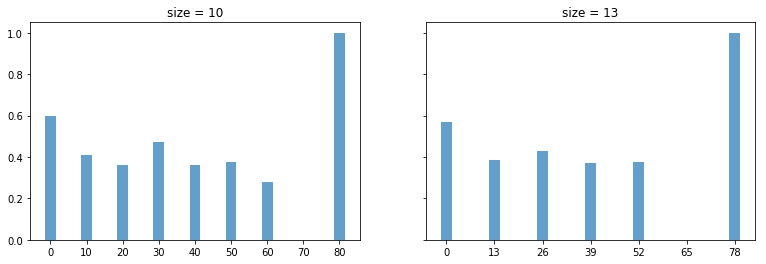

In [24]:
# the parameter size is a list of length 4
def Graph_Rate(size, Bucket, origin, width):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,4))
    #width = 3
    s = size[0]
    df = Rate(s, Bucket, origin)
    ax1.bar(df.index, df["Survived"], width, alpha=0.7)
    ax1.set_title('size = {}'.format(s))
    ax1.set_xticks(df.index)
    ax1.set_ylabel('Survival Rate')
    ax1.set_xlabel('{}'.format(Bucket))
    s = size[1]
    df = Rate(s, Bucket, origin)
    ax2.bar(df.index,df["Survived"], width, alpha=0.7)
    ax2.set_title('size = {}'.format(s))
    ax2.set_xticks(df.index)
    # second row
    f, (ax3, ax4) = plt.subplots(1, 2, sharey=True, figsize=(13,4))
    s = size[2]
    df = Rate(s, Bucket, origin)
    ax3.bar(df.index,df["Survived"], width, alpha=0.7)
    ax3.set_title('size = {}'.format(s))
    ax3.set_xticks(df.index)
    s = size[3]
    df = Rate(s, Bucket, origin)
    ax4.bar(df.index,df["Survived"], width, alpha=0.7)
    ax4.set_title('size = {}'.format(s))
    ax4.set_xticks(df.index)

size = [5, 8, 10, 13]
Graph_Rate(size, "AgeBucket", "Age", width=3)

From these graphs, we can see that when size = 5, some age buckets in the middle have similar survival rate with the bar right close to them. It means we can still merge these buckets and we have too many buckets. 

When size = 13, some differences between bars disappear due to taking average over large range of ages. 

Size 8 and 10 seem to be better than the other two in terms of capturing the trend, as well as preserving the differences. 

I would try numbers close to 8 and 10 in my experiments.

In [25]:
# Fill up missing values of Age first before dividing into buckets
train_data["Age"].fillna(train_data["Age"].median(), inplace=True)
vali_data["Age"].fillna(vali_data["Age"].median(), inplace=True)

In [26]:
# Remember to add to test set as well
size = 10
vali_data["AgeBucket"] = vali_data["Age"] // size * size

train_data["AgeBucket"] = train_data["Age"] // size * size
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()
vali_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.666667
10.0,0.375000
20.0,0.250000
30.0,0.325000
40.0,0.470588
50.0,0.625000
60.0,1.000000
70.0,0.000000


I will treat Age Bucket as Categorical values so delete 'Age' from numerical feature list and add 'AgeBucket' to cat_features

I add handle_unknown='ignore' to One hot encoder, because we only have one person in the age of 80. When we divide the training set and test set (train_data & vali_data), that person can only be assigned to one data set, so there might be an empty buckets in the other set depending on how large the bucket is. In order to make one hot ecoder work, I need to add handle_unknown='ignore'.

In [27]:
num_features = ["SibSp", "Parch", "Fare"]
cat_features = ["Sex", "Pclass", "AgeBucket"]

# the following code would be quite repetitive in later questions, so i write into a funtion to build up pipeline
def MyPipeline(num_features, cat_features):
    num_pipeline = Pipeline([
            ("select_numeric", DataFrameSelector( num_features )),
            ("imputer", SimpleImputer(strategy="median")),
        ])
    cat_pipeline = Pipeline([
            ("select_cat", DataFrameSelector( cat_features )),
            ("imputer", MostFrequentImputer()),
            ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
        ])
    preprocess_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return preprocess_pipeline

preprocess_pipeline = MyPipeline(num_features, cat_features)

X_train = preprocess_pipeline.fit_transform(train_data)
# Transform the test data too
#X_test = preprocess_pipeline.transform(test_data)
X_vali = preprocess_pipeline.transform(vali_data)

# get true y
y_train = train_data["Survived"]
y_vali = vali_data['Survived']

logistic_clf = linear_model.LogisticRegression(solver='liblinear')

# Fit the training set
_= logistic_clf.fit(X_train, y_train)
  
y_pred_lg = logistic_clf.predict(X_vali)

scores_lg = cross_val_score(logistic_clf, X_train, y_train, cv=5)

In [28]:
model = "Logistic Regression, bucketing version 1"
cross_val_avg = cross_val_avg = scores_lg.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=model, sc=cross_val_avg) )

accuracy = accuracy_score(y_vali, y_pred_lg, normalize=True)
print("{m:s}: Accuracy = {a:.2%}".format(m=model, a=accuracy) )


Logistic Regression, bucketing version 1: Avg cross val score = 0.79
Logistic Regression, bucketing version 1: Accuracy = 82.12%


Comparing to the first logistic model with Accuray 83.80%, age buckets of size 10 even decreases the accuracy. Prababilty, 10 is not a good size of buckets or the reason is my training set is not large enough.

Try a *different* bucketing scheme for `Age`

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [29]:
# Remember to add to test set as well
vali_data["AgeBucket2"] = vali_data["Age"] // 7 * 7

train_data["AgeBucket2"] = train_data["Age"] // 7 * 7
train_data[["AgeBucket2", "Survived"]].groupby(['AgeBucket2']).mean()

,Survived
AgeBucket2,
0.0,0.676471
7.0,0.388889
14.0,0.376471
21.0,0.385827
28.0,0.358268
35.0,0.474359
42.0,0.312500
49.0,0.411765
56.0,0.333333


In [30]:
num_features = ["SibSp", "Parch", "Fare"]
cat_features = ["Sex", "Pclass", "AgeBucket2"]

preprocess_pipeline = MyPipeline(num_features, cat_features)

X_train = preprocess_pipeline.fit_transform(train_data)
# Transform the test data too
X_vali = preprocess_pipeline.transform(vali_data)

# get true y
y_train = train_data["Survived"]
y_vali = vali_data['Survived']

logistic_clf = linear_model.LogisticRegression(solver='liblinear')

# Fit the training set
_= logistic_clf.fit(X_train, y_train)
  
y_pred_lg = logistic_clf.predict(X_vali)

scores_lg = cross_val_score(logistic_clf, X_train, y_train, cv=5)

In [31]:
model = "Logistic Regression, bucketing version 2"
cross_val_avg = cross_val_avg = scores_lg.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=model, sc=cross_val_avg) )

accuracy = accuracy_score(y_vali, y_pred_lg, normalize=True)
print("{m:s}: Accuracy = {a:.2%}".format(m=model, a=accuracy) )


Logistic Regression, bucketing version 2: Avg cross val score = 0.79
Logistic Regression, bucketing version 2: Accuracy = 84.36%


Comparing to the first logistic model with Accuray 83.80%%, age buckets of size 7 increase accuracy by around 1.5%.

# (Extra credit)  Perform more feature engineering

We will award extra points for each (up to a maximum of 3) transformation  judged to be well thought out.
This means that *you must clearly explain* your ideas, experiments and results.

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements
- Also replace the "???" with a description of your feature engineering.

Repeat this cell for each new feature engineering/transformation that you submit.

# 1. Fare Buckets
Just as age, each one dollar increment in Fare might not impact the prediction so it might be better to compare between buckets of Fare too.

- First, I will try several bucket choices and see which one is optimal
- The Max of Fare is around 500 from previous table


In [32]:
size = 30
vali_data["FareBucket"] = vali_data["Fare"] // size * size

train_data["FareBucket"] = train_data["Fare"] // size * size
train_data[["FareBucket", "Survived"]].groupby(['FareBucket']).count()

,Survived
FareBucket,
0.0,519
30.0,93
60.0,48
90.0,18
120.0,11
150.0,8
210.0,6
240.0,7
510.0,2


Look at Fare distribution, Most fare are concentrated below 90.

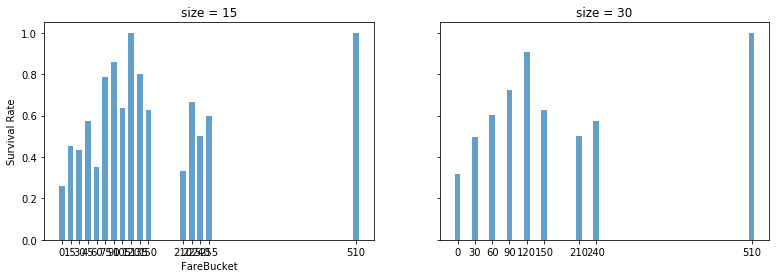

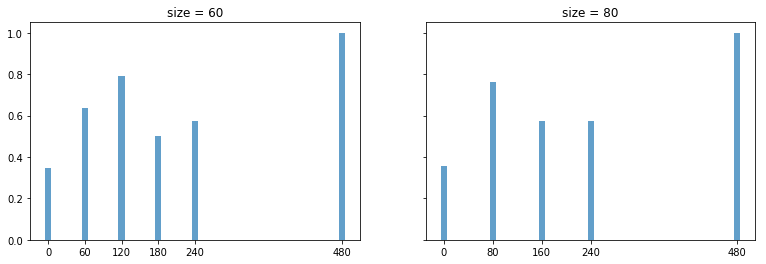

In [33]:
size = [15, 30, 60, 80]
Graph_Rate(size, "FareBucket", "Fare", width=10)

For small value of fare bucket size, there are Gaps bettween our data. It might affect our prediction due to lack of data in many categories

After a few trials, 70 has the best accuracy among these choices

In [34]:
size = 70
vali_data["FareBucket"] = vali_data["Fare"] // size * size

train_data["FareBucket"] = train_data["Fare"] // size * size
train_data[["FareBucket", "Survived"]].groupby(['FareBucket']).mean()

,Survived
FareBucket,
0.0,0.347200
70.0,0.725806
140.0,0.700000
210.0,0.538462
490.0,1.000000


In [35]:
num_features = ["SibSp","Parch"]
cat_features = ["Sex", "Pclass", "AgeBucket2", "FareBucket"]

preprocess_pipeline = MyPipeline(num_features, cat_features)

X_train = preprocess_pipeline.fit_transform(train_data)
# Transform the test data too
X_vali = preprocess_pipeline.transform(vali_data)

# get true y
y_train = train_data["Survived"]
y_vali = vali_data['Survived']

logistic_clf = linear_model.LogisticRegression(solver='liblinear')

# Fit the training set
_= logistic_clf.fit(X_train, y_train)
  
y_pred_lg = logistic_clf.predict(X_vali)

scores_lg = cross_val_score(logistic_clf, X_train, y_train, cv=5)

In [36]:
title = "Logistic Regression, FareBucket"
cross_val_avg = cross_val_avg = scores_lg.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=title, sc=cross_val_avg) )

accuracy = accuracy_score(y_vali, y_pred_lg, normalize=True)
print("{m:s}: Accuracy = {a:.2%}".format(m=title, a=accuracy) )

Logistic Regression, FareBucket: Avg cross val score = 0.79
Logistic Regression, FareBucket: Accuracy = 84.92%


The accuracy only increase a little bit, 0.6%, compared to the previous one with "Fare" and "AgeBucket2".

# 2. Include Name Title
Despite Name of passensers seems to be unimportant at first glance, the title included in their names might matter. They are Mr., Miss, Mrs. Master. and Dr. Mr. may have no difference with male, but Miss and Mrs indicate that if a women is married or not. She could be married with no spouse on the ship, so it is not the same as Sibsp too. 

To be related to survival rate, married women have their own family, so they probably have more responsibilities to stay alive.

I will extract this information as a categorical variable named title

This idea is inspired by https://www.kaggle.com/zhenqiliu/titanic-survival-python-solution

First, take a look at what titles we have in our training data.

In [37]:
def GetTitle(data):
    data.index = range(len(data))
    title = []
    Name = data["Name"]
    for i in range(len(data)):
        title.append(Name[i][Name[i].rfind(", ")+1:Name[i].rfind(".")])
    return title
# update both data sets
NameTitle = GetTitle(train_data)
train_data["Title"] = NameTitle

In [38]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket2,AgeBucket,FareBucket,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,21.0,20.0,0.0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35.0,30.0,70.0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,21.0,20.0,0.0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,30.0,0.0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,30.0,0.0,Mr


In [39]:
train_data[["Title", "Survived"]].groupby(['Title']).count()

,Survived
Title,
Col,2
Don,1
Dr,5
Lady,1
Major,2
Master,28
Miss,155
Mlle,2
Mme,1


Unfortunately, there are much more title than I can think of, some of them have the same or similar meaning, so we need to combine them.

Others (ex. Rev means a Christian cleric) are in a small amount, so I just combined them into "others".

Another reason for including others option is that in our test set, there might be new title that does not appear in our training set, but there should only be a small number of them.

In [40]:
# The following code is adjusted from the online link
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

def title_map(title):
    if title in ['Mr', 'Sir']:
        return 'Mr'
    elif title in ['Master']:
        return 'Master'
    elif title in ['Ms','Mlle','Miss']:
        return 'Miss'
    elif title in ['Mme','Mrs','Lady']:
        return 'Mrs'
    else:
        return 'Others'
    
train_data['Title'] = train_data['Name'].apply(get_title).apply(title_map)   
vali_data['Title'] = vali_data['Name'].apply(get_title).apply(title_map)

In [41]:
train_data[["Title", "Survived"]].groupby(['Title']).mean()

,Survived
Title,
Master,0.535714
Miss,0.715190
Mr,0.166667
Mrs,0.785714
Others,0.285714


The survival possibility follows this rank: Mrs > Miss > Master > Others > Mr

In [42]:
num_features = ["SibSp", "Parch"]
cat_features = ["Sex", "Pclass", "AgeBucket2","Title", "FareBucket"]

preprocess_pipeline = MyPipeline(num_features, cat_features)

X_train = preprocess_pipeline.fit_transform(train_data)
# Transform the test data too
X_vali = preprocess_pipeline.transform(vali_data)

# get true y
y_train = train_data["Survived"]
y_vali = vali_data['Survived']

logistic_clf = linear_model.LogisticRegression(solver='liblinear')

# Fit the training set
_= logistic_clf.fit(X_train, y_train)
  
y_pred_lg = logistic_clf.predict(X_vali)

scores_lg = cross_val_score(logistic_clf, X_train, y_train, cv=5)

In [43]:
title = "Logistic Regression, Name Tile"
cross_val_avg = cross_val_avg = scores_lg.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=title, sc=cross_val_avg) )

accuracy = accuracy_score(y_vali, y_pred_lg, normalize=True)
print("{m:s}: Accuracy = {a:.2%}".format(m=title, a=accuracy) )

Logistic Regression, Name Tile: Avg cross val score = 0.80
Logistic Regression, Name Tile: Accuracy = 87.71%


The accuracy is quite impressive. It is better than all my previous trials.

# 3. Combine Sibsp and Parch
siblings, spouse, parents and children are all family members. They are approaximately equal love under emergency condition.

In [44]:
train_data['Family'] = train_data['SibSp']+train_data['Parch']
vali_data['Family'] = vali_data['SibSp']+train_data['Parch']

train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket2,AgeBucket,FareBucket,Title,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,21.0,20.0,0.0,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,35.0,30.0,70.0,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,21.0,20.0,0.0,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,30.0,0.0,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,30.0,0.0,Mr,0
5,6,0,3,"Moran, Mr. James",male,28.0,0,0,330877,8.4583,NaN,Q,28.0,20.0,0.0,Mr,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,49.0,50.0,0.0,Mr,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0.0,0.0,0.0,Master,4
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,21.0,20.0,0.0,Mrs,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,14.0,10.0,0.0,Mrs,1


In [45]:
num_features = ["Family", "Fare"]
cat_features = ["Sex", "Pclass", "AgeBucket2","Title"]

preprocess_pipeline = MyPipeline(num_features, cat_features)

X_train = preprocess_pipeline.fit_transform(train_data)
# Transform the test data too
X_vali = preprocess_pipeline.transform(vali_data)

# get true y
y_train = train_data["Survived"]
y_vali = vali_data['Survived']

logistic_clf = linear_model.LogisticRegression(solver='liblinear')

# Fit the training set
_= logistic_clf.fit(X_train, y_train)
  
y_pred_lg = logistic_clf.predict(X_vali)

scores_lg = cross_val_score(logistic_clf, X_train, y_train, cv=5)

In [46]:
title = "Logistic Regression, Name Tile"
cross_val_avg = cross_val_avg = scores_lg.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=title, sc=cross_val_avg) )

accuracy = accuracy_score(y_vali, y_pred_lg, normalize=True)
print("{m:s}: Accuracy = {a:.2%}".format(m=title, a=accuracy) )

Logistic Regression, Name Tile: Avg cross val score = 0.81
Logistic Regression, Name Tile: Accuracy = 81.56%


The Accuracy decreases a lot, so SibSp and Parch should be considered separately and they impact survival in different ways.

Notice that my test set is small compared to the test set professor provided to us. So the accuracy might be noisy.

# (Extra, extra credit) Contest !

Come up with your best model for the Titanic !  Use any model and whatever feature engineering you'd like.

We will evaluate your model on a held-out dataset.  Top scorers will get extra credit.

## Rules
- You *may not* include any packages that are not part of the standard installation
    - they won't run on the grader's machine
- Your feature engineering *must* deal with missing data for all attributes
    - the evaluation set *will* have missing values for some features
    

**Question**
Replace the 0 values in the following cell with your answers, and execute the print statements

In [47]:
# Feature transformation to test set you need
vali_data["AgeBucket2"] = vali_data["Age"] // 7 * 7
vali_data['Title'] = vali_data['Name'].apply(get_title).apply(title_map)

num_features = ["SibSp", "Parch", "Fare"]
cat_features = ["Sex", "Pclass", "AgeBucket2","Title", "Embarked", "Cabin"]

preprocess_pipeline = MyPipeline(num_features, cat_features)

X_train = preprocess_pipeline.fit_transform(train_data)
# Transform the test data too
X_vali = preprocess_pipeline.transform(vali_data)

# get true y
y_train = train_data["Survived"]
y_vali = vali_data['Survived']

logistic_clf = linear_model.LogisticRegression(solver='liblinear')

# Fit the training set
_= logistic_clf.fit(X_train, y_train)
  
y_pred_lg = logistic_clf.predict(X_vali)

scores_lg = cross_val_score(logistic_clf, X_train, y_train, cv=5)

In [48]:
title = "Titanic contest"
cross_val_avg = cross_val_avg = scores_lg.mean()

print("{m:s}: Avg cross val score = {sc:3.2f}".format(m=title, sc=cross_val_avg) )

accuracy = accuracy_score(y_vali, y_pred_lg, normalize=True)
print("{m:s}: Accuracy = {a:.2%}".format(m=title, a=accuracy) )

Titanic contest: Avg cross val score = 0.80
Titanic contest: Accuracy = 89.39%


In [49]:
print("Done")

Done
